<a href="https://colab.research.google.com/github/mahmud-nobe/Cluster-Membership/blob/master/GMM%2BRF/Direct_Replication_M67_GMM%2BRF_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction


In this notebook, I replicated the first part of Gao (2018) paper where they used GMM and Random Forest (RF) to get the membership for M67 open cluster.


## Reference

* Gao, X. (2018). A Machine-learning-based Investigation of the Open Cluster M67. *The Astrophysical Journal*, 869(1). https://doi.org/10.3847/1538-4357/aae8dd

## Replication GMM

Using GMM on the preprocessed data to get a reliable training dataset for Random Forest

### Importing packages

In [ ]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier

In [ ]:
!pip install astroquery

     |████████████████████████████████| 4.5 MB 7.2 MB/s 
     |████████████████████████████████| 802 kB 59.5 MB/s 
     |████████████████████████████████| 54 kB 2.7 MB/s 
     |████████████████████████████████| 3.6 MB 45.2 MB/s 
  Created wheel for mimeparse: filename=mimeparse-0.1.3-py3-none-any.whl size=3864 sha256=cdb4fbd487411502bf5e8d1659f9463da6abc4854223745e01675ae41df9d56f
  Stored in directory: /root/.cache/pip/wheels/49/b4/2d/0081759ae1833bd694024801f7aacddcda8a687e8d5fbaeebd
Successfully built mimeparse


In [ ]:
# import astroquery
import astropy.units as u
import astropy.coordinates as coord
from astroquery.gaia import Gaia
from astroquery.gaia import TapPlus, GaiaClass   
from astroquery.vizier import Vizier


### Finding GAIA Data

In [ ]:
## making a GAIA cone_search of 1 degree radius around M67 center
## We are using DR2 as the Gao (2018) paper used DR2

coordinate = coord.SkyCoord.from_name('M67')
print(coordinate)
radius = u.Quantity(1, u.deg)
Gaia.ROW_LIMIT = -1
# table = "gaiaedr3.gaia_source"
table = "gaiadr2.gaia_source"
j = Gaia.cone_search_async(coordinate, radius)
r = j.get_results()
print(type(r))

<SkyCoord (ICRS): (ra, dec) in deg
    (132.846, 11.814)>
INFO: Query finished. [astroquery.utils.tap.core]
<class 'astropy.table.table.Table'>


In [ ]:
## save the ASCII table as a panadas dataframe
all_stars = r.to_pandas()
all_stars


,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,...,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,phot_variable_flag,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,datalink_url,dist
0,1635721458409799680,Gaia DR2 604917629355038848,604917629355038848,309606362,2015.5,132.845427,0.033842,11.813721,0.022365,1.129222,0.042616,26.497473,-10.956961,0.071723,-3.093306,0.051006,-0.195550,-0.170198,-0.157318,-0.074163,0.217768,0.129410,-0.505363,0.261068,0.050572,-0.386716,270,270,268,2,6.030247,426.040680,0.000000,0.000000e+00,31,True,245.371384,1.627914,0.006196,0.055473,...,29,114671.304674,76.650655,1496.025146,12.113283,1.204024,1,0.741670,0.292775,0.448895,NaN,NaN,0,NaN,NaN,NaN,NOT_AVAILABLE,215.691180,31.920163,131.975615,-5.602846,100002,6320.979980,6052.333496,6652.666504,NaN,NaN,NaN,NaN,NaN,NaN,200111,1.939404,1.750837,2.115395,5.409647,5.116649,5.702646,https://gea.esac.esa.int/data-server/datalink/...,0.000629
1,1635721458409799680,Gaia DR2 604917698073552640,604917698073552640,524821416,2015.5,132.842932,0.678479,11.812019,0.385532,1.326860,0.821405,1.615354,-4.899287,1.382265,-3.937188,0.926115,-0.158810,-0.202182,-0.277384,-0.048904,0.174523,0.192990,-0.644295,0.224496,0.102105,-0.366163,282,0,281,1,-0.289480,268.599243,0.000000,0.000000e+00,31,False,0.059617,1.499148,0.113118,0.078844,...,32,343.700852,8.615749,39.892162,18.421469,2.536617,0,2.095335,0.400385,1.694950,NaN,NaN,0,NaN,NaN,NaN,NOT_AVAILABLE,215.691796,31.917233,131.973718,-5.605147,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,https://gea.esac.esa.int/data-server/datalink/...,0.003599
2,1635721458409799680,Gaia DR2 604917732434252032,604917732434252032,1037136882,2015.5,132.847883,0.047155,11.818284,0.028357,1.113444,0.059270,18.785810,-11.261058,0.099747,-3.060736,0.069823,-0.203317,-0.193954,-0.088213,-0.091070,0.198510,0.143394,-0.505099,0.266576,0.071134,-0.393377,305,0,304,1,-0.531459,285.544067,0.000000,0.000000e+00,31,False,9.124626,1.523387,0.008625,0.048264,...,27,6389.556146,26.115426,244.665970,15.248243,1.261143,0,1.213900,0.520187,0.693712,NaN,NaN,0,NaN,NaN,NaN,NOT_AVAILABLE,215.687482,31.924256,131.976693,-5.597801,100001,4880.000000,4811.924805,5016.500000,NaN,NaN,NaN,NaN,NaN,NaN,200111,0.748697,0.708507,0.770030,0.286409,0.253650,0.319167,https://gea.esac.esa.int/data-server/datalink/...,0.004667
3,1635721458409799680,Gaia DR2 604917732434325248,604917732434325248,1685360922,2015.5,132.845628,0.023422,11.820310,0.014362,1.125087,0.028212,39.879951,-10.902709,0.049980,-3.153121,0.033065,-0.114846,-0.047632,-0.194107,-0.122447,0.224214,0.041213,-0.483801,0.205225,0.025290,-0.329040,263,0,258,5,1.481120,287.074982,0.062990,1.277349e+00,31,False,83.750946,1.654632,0.003962,0.068040,...,28,62416.143422,47.694076,1308.677124,12.773678,1.201937,0,0.629848,0.236272,0.393577,NaN,NaN,0,NaN,NaN,NaN,NOT_AVAILABLE,215.684227,31.923100,131.974

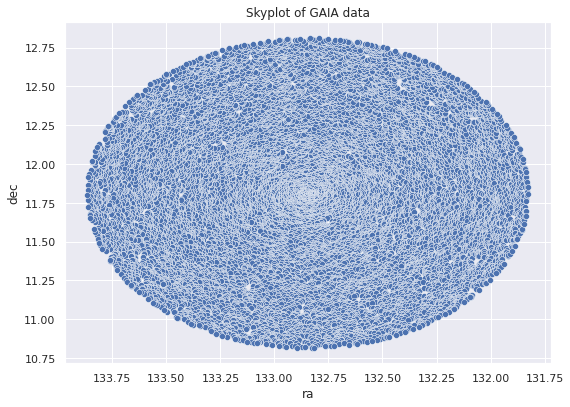

In [ ]:
## plotting the skyplot 

sns.set(rc={'figure.figsize':(8.7,6.27)})

skyplot = sns.scatterplot(x='ra', y='dec', data = all_stars)
skyplot.invert_xaxis()
plt.title('Skyplot of GAIA data')
plt.show()

### Applying Filter:

In [ ]:
# calculating the distance from the parallax
all_stars['distance_pc'] = 1/(all_stars.parallax*0.001)

In [ ]:
print(len(all_stars))

# positive parallax
all_stars = all_stars[all_stars['parallax'] >= 0]
print(len(all_stars))

# dropping rows with null values in required columns
all_stars = all_stars[all_stars.loc[:, 'pmra'].notnull()]
all_stars = all_stars[all_stars.loc[:, 'parallax'].notnull()]
all_stars = all_stars[all_stars.loc[:, 'bp_rp'].notnull()]
print(len(all_stars))

# defining proper motion (pm) range
all_stars = all_stars[(abs(all_stars['pmra']) < 20) & (abs(all_stars['pmdec']) < 20)]
print(len(all_stars))

# taking stars within 60' = 1 deg radius
all_stars = all_stars[all_stars['dist'] < (60/60)]
print(len(all_stars))

# taking stars within a distance of 500 - 1600 pc
all_stars = all_stars[((all_stars['distance_pc']) < 1600) & ((all_stars['distance_pc']) > 500)]
print(len(all_stars))


19423
14198
14098
12972
12972
7316


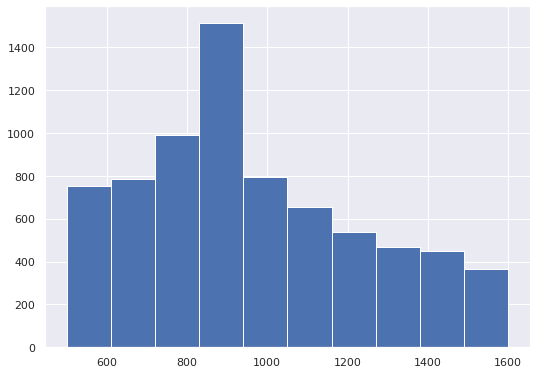

In [ ]:
plt.hist(all_stars.distance_pc)
plt.show()

### Building GMM Model

In [ ]:
def get_member(working_data, feature_columns, cutoff = 0.6):
    features = working_data.loc[:,feature_columns].dropna()

    # normalizing the features
    scaled_features = pd.DataFrame({})
    for column in features.columns:
        scaled_features[column] = (features[column] - np.median(features[column]))/np.std(features[column])

    from sklearn.mixture import GaussianMixture
    gmm = GaussianMixture(n_components=2)
    gmm.fit(scaled_features)

    #predictions from gmm
    labels = gmm.predict(scaled_features)
    probs = gmm.predict_proba(scaled_features)

    working_data.loc[:, 'PMemb'] = probs[:, 0]
    working_data.loc[:, 'gmm_label'] = labels

    non_member = working_data[working_data['PMemb'] <= (1-cutoff)]
    member = working_data[working_data['PMemb'] >= cutoff]

    if np.std(member.pmra) > np.std(non_member.pmra):
        working_data.loc[:, 'PMemb'] = probs[:, 1]
        working_data.loc[:, 'gmm_label'] = 1-labels
        non_member = working_data[working_data['PMemb'] <= (1-cutoff)]
        member = working_data[working_data['PMemb'] >= cutoff]
        

    return member, non_member, gmm

In [ ]:
# I used only three parameteres as in my opinion the RA and dec is already 
# considered while selecting a very smaller area

feature_columns = ['pmra', 'pmdec', 'ra', 'dec', 'parallax']

member, non_member, gmm = get_member(all_stars, feature_columns, cutoff=0.6)

### Comparing with Gao Paper

#### Members and Covariance Matrix

Depending on the cutoff on PMemb, the number of stars are following:
* Likely member (PMemb >= 0.6) = 1401
* High-probability member (PMemb >= 0.95) = 1256
* Zero-probability field star (PMemb = 0) = 5720

And the covariance matrix for field stars group, $\sum_f$ and the member group $\sum_c$ are following:


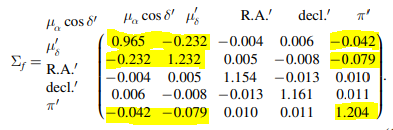

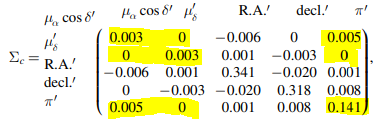

In [ ]:
gmm.covariances_.round(3)

array([[[ 9.630e-01, -2.320e-01, -5.000e-03,  4.000e-03, -4.200e-02],
        [-2.320e-01,  1.236e+00,  5.000e-03, -1.000e-02, -7.900e-02],
        [-5.000e-03,  5.000e-03,  1.158e+00, -1.300e-02,  8.000e-03],
        [ 4.000e-03, -1.000e-02, -1.300e-02,  1.163e+00,  7.000e-03],
        [-4.200e-02, -7.900e-02,  8.000e-03,  7.000e-03,  1.205e+00]],

       [[ 3.000e-03, -0.000e+00, -6.000e-03, -0.000e+00,  5.000e-03],
        [-0.000e+00,  3.000e-03,  1.000e-03, -3.000e-03, -0.000e+00],
        [-6.000e-03,  1.000e-03,  3.420e-01, -2.000e-02, -0.000e+00],
        [-0.000e+00, -3.000e-03, -2.000e-02,  3.210e-01,  7.000e-03],
        [ 5.000e-03, -0.000e+00, -0.000e+00,  7.000e-03,  1.500e-01]]])

In [ ]:
len(member), len(non_member)

(1416, 5867)

In [ ]:
print('n(PMemb >= 0.6) =', sum(all_stars.PMemb >= 0.6))
print('n(PMemb >= 0.95) =', sum(all_stars.PMemb >= 0.95))
print('n(PMemb <= 0.0001) =', sum(all_stars.PMemb <= 0.0001))

n(PMemb >= 0.6) = 1416
n(PMemb >= 0.95) = 1261
n(PMemb <= 0.0001) = 5691


#### Figure 1
PMemb histogram and the plot for PMemb vs G band magnitude.

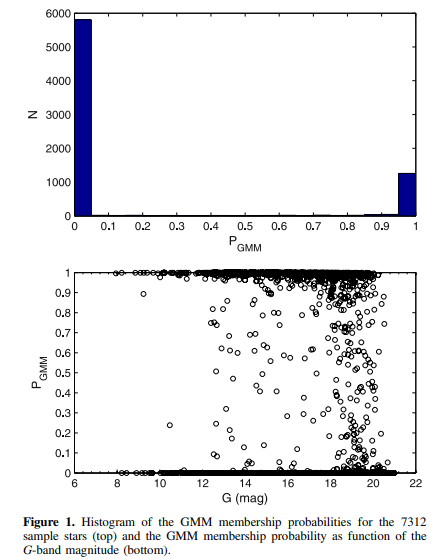


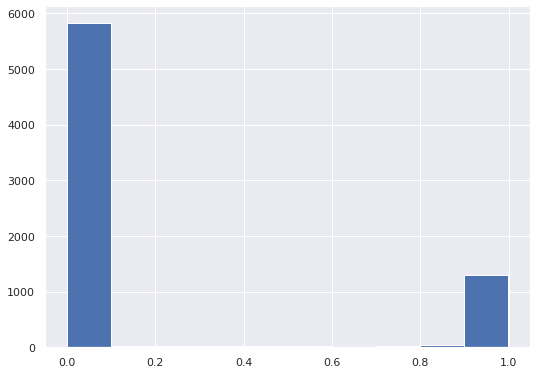

In [ ]:
plt.hist(all_stars.PMemb)
plt.show()

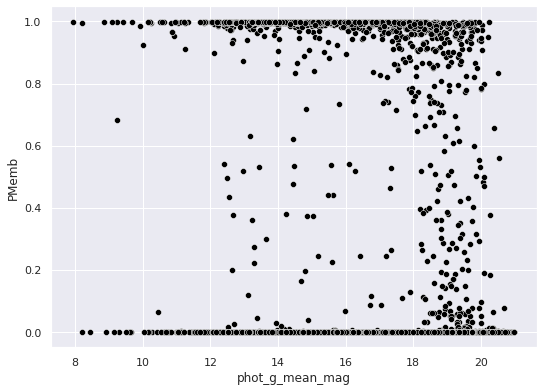

In [ ]:
sns.scatterplot(x='phot_g_mean_mag', y = 'PMemb', data = all_stars, color = 'black')
plt.show()

#### Figure 2
Proper Motion Plot

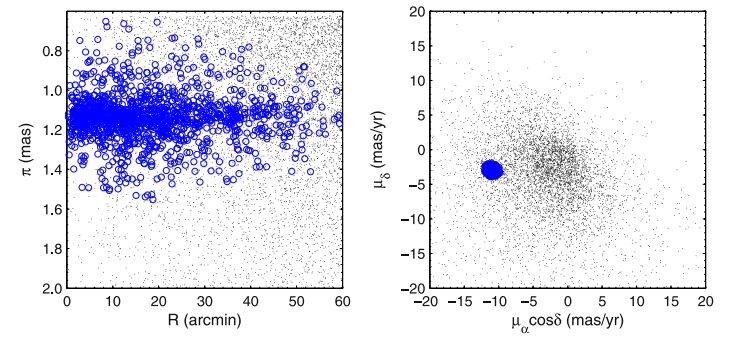

In [ ]:
training_data = pd.concat([member.assign(member=1), non_member.assign(member=0)])
training_data.head()

,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,...,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,phot_variable_flag,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,datalink_url,dist,distance_pc,PMemb,gmm_label,member
0,1635721458409799680,Gaia DR2 604917629355038848,604917629355038848,309606362,2015.5,132.845427,0.033842,11.813721,0.022365,1.129222,0.042616,26.497473,-10.956961,0.071723,-3.093306,0.051006,-0.195550,-0.170198,-0.157318,-0.074163,0.217768,0.129410,-0.505363,0.261068,0.050572,-0.386716,270,270,268,2,6.030247,426.040680,0.000000,0.000000,31,True,245.371384,1.627914,0.006196,0.055473,...,12.113283,1.204024,1,0.741670,0.292775,0.448895,NaN,NaN,0,NaN,NaN,NaN,NOT_AVAILABLE,215.691180,31.920163,131.975615,-5.602846,100002,6320.979980,6052.333496,6652.666504,NaN,NaN,NaN,NaN,NaN,NaN,200111,1.939404,1.750837,2.115395,5.409647,5.116649,5.702646,https://gea.esac.esa.int/data-server/datalink/...,0.000629,885.565629,0.998139,0,1
2,1635721458409799680,Gaia DR2 604917732434252032,604917732434252032,1037136882,2015.5,132.847883,0.047155,11.818284,0.028357,1.113444,0.059270,18.785810,-11.261058,0.099747,-3.060736,0.069823,-0.203317,-0.193954,-0.088213,-0.091070,0.198510,0.143394,-0.505099,0.266576,0.071134,-0.393377,305,0,304,1,-0.531459,285.544067,0.000000,0.000000,31,False,9.124626,1.523387,0.008625,0.048264,...,15.248243,1.261143,0,1.213900,0.520187,0.693712,NaN,NaN,0,NaN,NaN,NaN,NOT_AVAILABLE,215.687482,31.924256,131.976693,-5.597801,100001,4880.000000,4811.924805,5016.500000,NaN,NaN,NaN,NaN,NaN,NaN,200111,0.748697,0.708507,0.770030,0.286409,0.253650,0.319167,https://gea.esac.esa.int/data-server/datalink/...,0.004667,898.114453,0.997370,0,1
3,1635721458409799680,Gaia DR2 604917732434325248,604917732434325248,1685360922,2015.5,132.845628,0.023422,11.820310,0.014362,1.125087,0.028212,39.879951,-10.902709,0.049980,-3.153121,0.033065,-0.114846,-0.047632,-0.194107,-0.122447,0.224214,0.041213,-0.483801,0.205225,0.025290,-0.329040,263,0,258,5,1.481120,287.074982,0.062990,1.277349,31,False,83.750946,1.654632,0.003962,0.068040,...,12.773678,1.201937,0,0.629848,0.236272,0.393577,NaN,NaN,0,NaN,NaN,NaN,NOT_AVAILABLE,215.684227,31.923100,131.974006,-5.596452,100001,6845.333496,6356.000000,6994.666504,0.2835,0.1735,0.5501,0.1392,0.0740,0.2746,200111,1.255830,1.202780,1.456640,3.119858,2.927116,3.312600,https://gea.esac.esa.int/data-server/datalink/...,0.006326,888.820446,0.997757,0,1
4,1635721458409799680,Gaia DR2 604917629355039360,604917629355039360,340729517,2015.5,132.846939,0.039546,11.807362,0.023041,1.111626,0.047573,23.366507,-10.978362,0.085649,-3.395680,0.056500,-0.188175,-0.164693,0.031988,-0.101328,0.184592,0.083166,-0.472924,0.213145,0.061962,-0.342663,288,0,288,0,12.284073,686.185303,0.226969,13.566716,31,False,14.085754,1.546124,0.006565,0.058586,...,13.436893,1.238919,0,1.079499,0.455420,0.624079,NaN,NaN,0,NaN,NaN,NaN,NOT_AVAILABLE,215.698714,31.918846,131.978783,-5.608563,100001,4932.049805,4844.333496,5044.100098,1.09

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


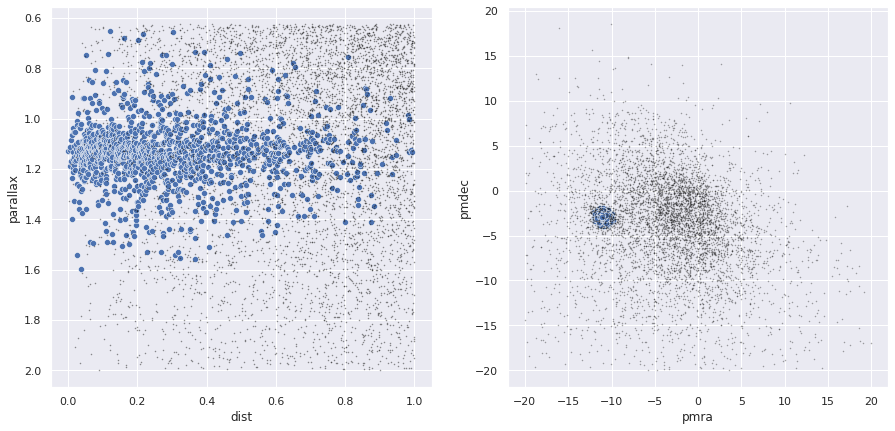

In [ ]:
#member = features[features['cluster'] == 1]
#non_member = features[features['cluster'] == 0]
plt.figure(figsize = (15,7))

plt.subplot(121)
plt.plot(non_member['dist'], non_member['parallax'], 'k.',  alpha = 0.5,
         markersize = 1)
plt.gca().invert_yaxis()
sns.scatterplot('dist', 'parallax', data = member)
#plt.title('Member')

plt.subplot(122)
plt.plot(non_member['pmra'], non_member['pmdec'], 'k.', alpha = 0.4, 
         markersize = 1)
sns.scatterplot('pmra', 'pmdec', data = member)
#plt.title('Non Member')
plt.show()

#### Figure 3: CMD
Color-Magnitude Diagram

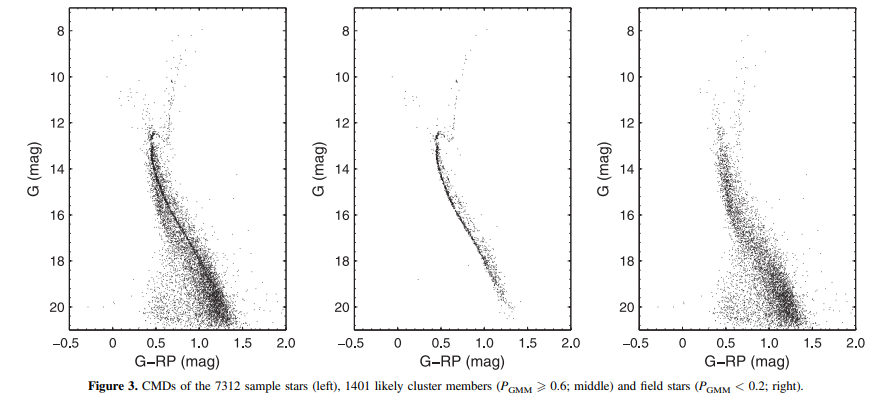

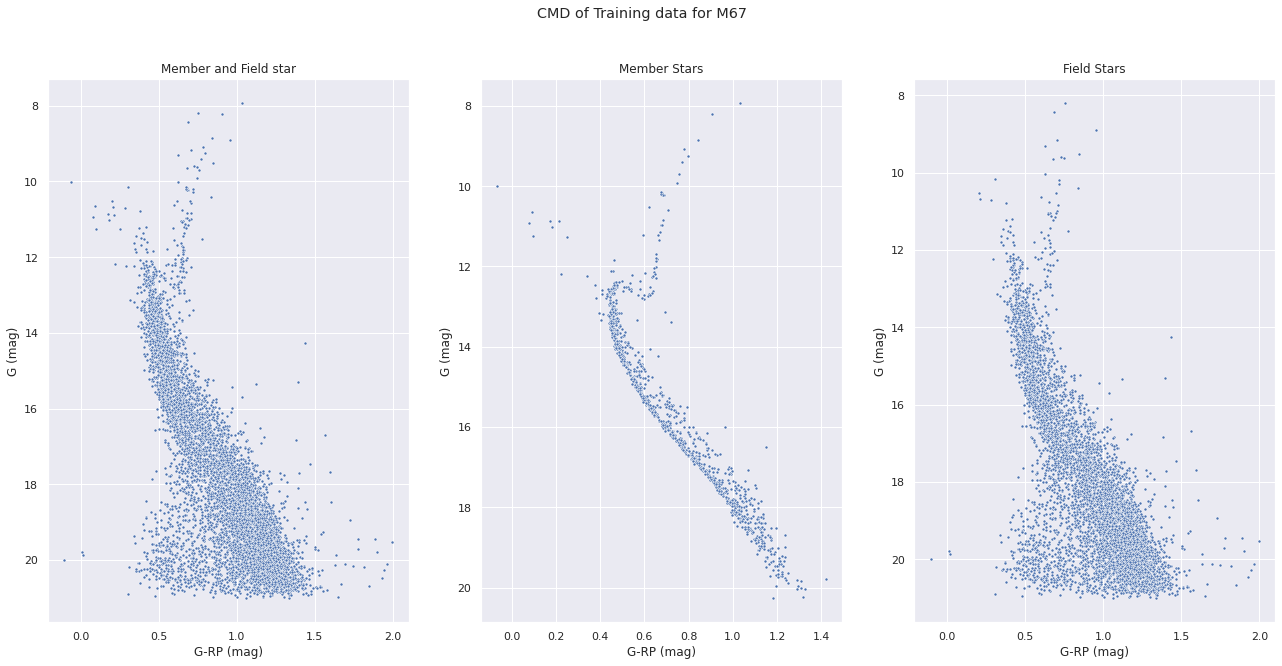

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(22,10))
fig.suptitle('CMD of Training data for M67')

sns.scatterplot(x = 'g_rp', y='phot_g_mean_mag',
                data = training_data, ax = axes[0], marker = '.')
axes[0].set_title('Member and Field star')
axes[0].set_xlabel('G-RP (mag)')
axes[0].set_ylabel('G (mag)')
axes[0].invert_yaxis()

sns.scatterplot(x = 'g_rp', y='phot_g_mean_mag', marker = '.',
                data = member, ax = axes[1])
axes[1].set_title('Member Stars')
axes[1].set_xlabel('G-RP (mag)')
axes[1].set_ylabel('G (mag)')
axes[1].invert_yaxis()

sns.scatterplot(x = 'g_rp', y='phot_g_mean_mag',  marker = '.',
                data = non_member[non_member.PMemb < 0.2], ax = axes[2])
axes[2].set_title('Field Stars')
axes[2].invert_yaxis()
axes[2].set_xlabel('G-RP (mag)')
axes[2].set_ylabel('G (mag)')

plt.show()


#### Distribution of features

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

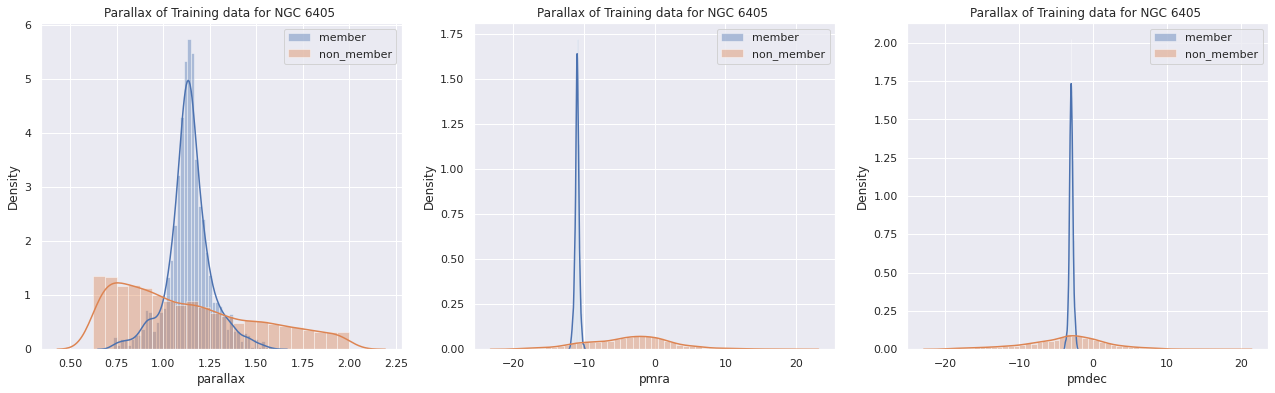

In [ ]:
plt.figure(figsize = (22,6))

plt.subplot(131)
sns.distplot(member.parallax, label='member')
sns.distplot(non_member.parallax, label = 'non_member')
plt.title('Parallax of Training data for NGC 6405 ')
plt.legend()

plt.subplot(132)
sns.distplot(member.pmra, label='member')
sns.distplot(non_member.pmra, label = 'non_member')
plt.title('Parallax of Training data for NGC 6405 ')
plt.legend()

plt.subplot(133)
sns.distplot(member.pmdec, label='member')
sns.distplot(non_member.pmdec, label = 'non_member')
plt.title('Parallax of Training data for NGC 6405 ')
plt.legend()

plt.show()

## Replication: Random Forest

Here we used the training data retrieved from GMM model to train a random forest model. Then predicted the cluster membership for a larger radius (2.5 degree) around the cluster center.

### Training Data

In [ ]:
member = member[member.PMemb >= 0.95]
non_member = non_member[non_member.PMemb <= 0.0001]

training_data = pd.concat([member.assign(member=1), non_member.assign(member=0)])
training_data.head()

,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,...,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,phot_variable_flag,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,datalink_url,dist,distance_pc,PMemb,gmm_label,member
0,1635721458409799680,Gaia DR2 604917629355038848,604917629355038848,309606362,2015.5,132.845427,0.033842,11.813721,0.022365,1.129222,0.042616,26.497473,-10.956961,0.071723,-3.093306,0.051006,-0.195550,-0.170198,-0.157318,-0.074163,0.217768,0.129410,-0.505363,0.261068,0.050572,-0.386716,270,270,268,2,6.030247,426.040680,0.000000,0.000000,31,True,245.371384,1.627914,0.006196,0.055473,...,12.113283,1.204024,1,0.741670,0.292775,0.448895,NaN,NaN,0,NaN,NaN,NaN,NOT_AVAILABLE,215.691180,31.920163,131.975615,-5.602846,100002,6320.979980,6052.333496,6652.666504,NaN,NaN,NaN,NaN,NaN,NaN,200111,1.939404,1.750837,2.115395,5.409647,5.116649,5.702646,https://gea.esac.esa.int/data-server/datalink/...,0.000629,885.565629,0.999435,0,1
2,1635721458409799680,Gaia DR2 604917732434252032,604917732434252032,1037136882,2015.5,132.847883,0.047155,11.818284,0.028357,1.113444,0.059270,18.785810,-11.261058,0.099747,-3.060736,0.069823,-0.203317,-0.193954,-0.088213,-0.091070,0.198510,0.143394,-0.505099,0.266576,0.071134,-0.393377,305,0,304,1,-0.531459,285.544067,0.000000,0.000000,31,False,9.124626,1.523387,0.008625,0.048264,...,15.248243,1.261143,0,1.213900,0.520187,0.693712,NaN,NaN,0,NaN,NaN,NaN,NOT_AVAILABLE,215.687482,31.924256,131.976693,-5.597801,100001,4880.000000,4811.924805,5016.500000,NaN,NaN,NaN,NaN,NaN,NaN,200111,0.748697,0.708507,0.770030,0.286409,0.253650,0.319167,https://gea.esac.esa.int/data-server/datalink/...,0.004667,898.114453,0.999209,0,1
3,1635721458409799680,Gaia DR2 604917732434325248,604917732434325248,1685360922,2015.5,132.845628,0.023422,11.820310,0.014362,1.125087,0.028212,39.879951,-10.902709,0.049980,-3.153121,0.033065,-0.114846,-0.047632,-0.194107,-0.122447,0.224214,0.041213,-0.483801,0.205225,0.025290,-0.329040,263,0,258,5,1.481120,287.074982,0.062990,1.277349,31,False,83.750946,1.654632,0.003962,0.068040,...,12.773678,1.201937,0,0.629848,0.236272,0.393577,NaN,NaN,0,NaN,NaN,NaN,NOT_AVAILABLE,215.684227,31.923100,131.974006,-5.596452,100001,6845.333496,6356.000000,6994.666504,0.2835,0.1735,0.5501,0.1392,0.0740,0.2746,200111,1.255830,1.202780,1.456640,3.119858,2.927116,3.312600,https://gea.esac.esa.int/data-server/datalink/...,0.006326,888.820446,0.999332,0,1
4,1635721458409799680,Gaia DR2 604917629355039360,604917629355039360,340729517,2015.5,132.846939,0.039546,11.807362,0.023041,1.111626,0.047573,23.366507,-10.978362,0.085649,-3.395680,0.056500,-0.188175,-0.164693,0.031988,-0.101328,0.184592,0.083166,-0.472924,0.213145,0.061962,-0.342663,288,0,288,0,12.284073,686.185303,0.226969,13.566716,31,False,14.085754,1.546124,0.006565,0.058586,...,13.436893,1.238919,0,1.079499,0.455420,0.624079,NaN,NaN,0,NaN,NaN,NaN,NOT_AVAILABLE,215.698714,31.918846,131.978783,-5.608563,100001,4932.049805,4844.333496,5044.100098,1.09

In [ ]:
# Examining the descriptive statistics of each column
training_data.describe()

,solution_id,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,astrometric_matched_observations,visibility_periods_used,...,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,dist,distance_pc,PMemb,gmm_label,member
count,6.952000e+03,6.952000e+03,6.952000e+03,6952.0,6952.000000,6952.000000,6952.000000,6952.000000,6952.000000,6952.000000,6952.000000,6952.000000,6952.000000,6952.000000,6952.000000,6952.000000,6952.000000,6952.000000,6952.000000,6952.000000,6952.000000,6952.000000,6952.000000,6952.000000,6952.000000,6952.000000,6952.000000,6952.000000,6952.000000,6952.000000,6952.000000,6952.000000,6952.000000,6952.0,6952.000000,6946.000000,6946.000000,6952.000000,6952.000000,6952.000000,...,6952.000000,6952.000000,6952.000000,6952.000000,6952.000000,6952.000000,6952.000000,6952.000000,172.000000,172.000000,6952.00000,172.000000,172.000000,172.000000,6952.000000,6952.000000,6952.000000,6952.000000,2509.000000,2509.000000,2509.000000,2509.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2425.0,2425.000000,2425.000000,2425.000000,2425.000000,2425.000000,2425.000000,6952.000000,6952.000000,6.952000e+03,6952.000000,6952.000000
mean,1.635721e+18,6.035156e+17,8.538759e+08,2015.5,132.832747,0.304740,11.815882,0.198704,1.128831,0.382945,10.781534,-4.615680,0.639612,-3.604488,0.429041,-0.314200,-0.228404,-0.275247,0.158726,0.239968,0.290676,-0.684007,0.428269,-0.152263,-0.401508,322.463032,12.959868,320.160529,2.302503,1.556315,427.745483,0.276417,3.097709,31.0,20.232361,1.463754,0.052493,0.041263,36.970368,12.218211,...,32.427976,356.438477,16.773708,1.400905,0.029776,1.541258,0.666585,0.874674,28.353223,1.632554,0.31286,5357.558105,3.427325,-0.079942,215.682318,31.908762,131.962936,-5.603581,100015.449980,5335.248535,5157.875000,5590.793457,0.327124,0.184721,0.513696,0.161475,0.090806,0.253665,200111.0,1.422986,1.314135,1.516081,3.632524,3.375423,3.889622,0.598221,966.044500,1.804154e-01,0.818613,0.181387
std,0.000000e+00,3.051381e+15,4.853574e+08,0.0,0.470426,0.345950,0.470440,0.228036,0.337830,0.427940,12.376592,6.286309,0.720456,5.139018,0.501411,0.129717,0.156072,0.146812,0.154386,0.187920,0.142700,0.086241,0.184278,0.219767,0.127528,47.856410,61.903445,47.525939,2.484967,7.406078,2024.593384,0.597021,58.988580,0.0,56.382202,0.132474,0.056021,0.031020,5.294518,0.874845,...,354.974341,474.164246,2.212619,0.218088,0.169980,0.553267,0.322774,0.283159,24.135270,2.233401,2.05403,683.494385,0.696027,0.269972,0.554831,0.459910,0.465007,0.468154,169.054059,657.477478,634.153015,729.912720,0.317145,0.247376,0.382329,0.157299,0.121746,0.189929,0.0,2.501879,2.357275,2.643748,23.314028,21.835037,24.796238,0.274930,282.287977,3.833191e-01,0.385366,0.385366
min,1.635721e+18,5.986135e+17,2.657300e+04,2015.5,131.826966,0.017678,10.818079,0.011441,0.625008,0.021383,0.267490,-19.999044,0.037077,-19.966204,0.024244,-0.944230,-0.896278,-0.847718,-0.713499,-0.510428,-0.711816,-

In [ ]:
# Choosing the features

feature_columns = ['pmra', 'pmdec', 'ra', 'dec',
                   'parallax', 'phot_g_mean_mag',
                   "phot_bp_mean_mag", 'phot_rp_mean_mag',
                   'bp_rp', 'bp_g', 'g_rp']

features = training_data.loc[:,feature_columns]
targets = training_data['member']

In [ ]:
# Dropping the NULL values from the using training set
# adding features and targets in a training set
training_set = pd.concat((features, targets), axis=1)

# dropping NA
training_set = training_set.dropna()

# finding where dtype is float64
float64_data = np.where(training_set.dtypes == 'float64')[0] 

# change the data type to float32 from float64
training_set.iloc[:, float64_data] = training_set.iloc[:, float64_data].astype('float32')


# set features, targets again
features, targets = training_set.iloc[:,:-1], training_set.iloc[:,-1]

features.describe()

,pmra,pmdec,ra,dec,parallax,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,bp_rp,bp_g,g_rp
count,6952.000000,6952.000000,6952.000000,6952.000000,6952.000000,6952.000000,6952.000000,6952.000000,6952.000000,6952.000000,6952.000000
mean,-4.615677,-3.604484,132.832779,11.815845,1.128832,17.648365,18.314987,16.773708,1.541258,0.666585,0.874674
std,6.286309,5.139015,0.470426,0.470440,0.337829,2.420205,2.571546,2.212619,0.553267,0.322774,0.283159
min,-19.999044,-19.966204,131.826965,10.818079,0.625008,7.943599,8.883092,6.912045,-0.142782,-1.010054,-0.105911
25%,-10.714220,-6.088152,132.487499,11.472959,0.859284,15.882435,16.364204,15.235474,1.037360,0.399820,0.617733
50%,-4.496929,-3.001631,132.832268,11.814476,1.101752,18.245262,19.107480,17.265498,1.562587,0.647237,0.891215
75%,-0.278246,-0.831341,133.172897,12.157200,1.314047,19.681985,20.518398,18.586138,2.009539,0.913029,1.115398
max,19.932800,18.545561,133.863800,12.810881,1.998361,20.992826,22.350058,20.603453,3.014662,1.654076,1.996153


In [ ]:
targets.value_counts()

0    5691
1    1261
Name: member, dtype: int64

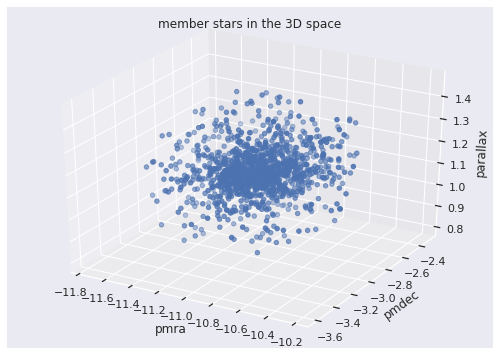

In [ ]:
from mpl_toolkits.mplot3d import Axes3D


ax = plt.figure().gca(projection='3d')

ax.scatter(member.pmra, member.pmdec, member.parallax)
ax.set_xlabel('pmra')
ax.set_ylabel('pmdec')
ax.set_zlabel('parallax')
plt.title('member stars in the 3D space')
plt.show()


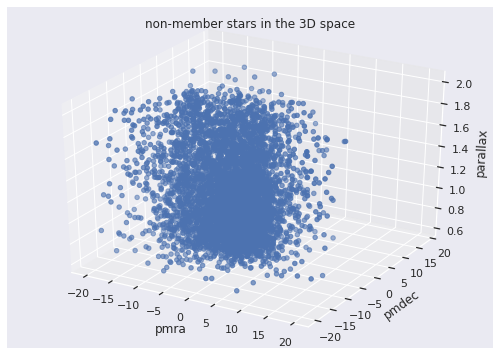

In [ ]:
ax = plt.figure().gca(projection='3d')

ax.scatter(non_member.pmra, non_member.pmdec, non_member.parallax)
ax.set_xlabel('pmra')
ax.set_ylabel('pmdec')
ax.set_zlabel('parallax')
plt.title('non-member stars in the 3D space')
plt.show()


### Feature Importance

In [ ]:
# Use Random Forest on whole dataset using 100 different trees 
rfc = RandomForestClassifier(n_estimators = 100, oob_score = True)
rfc.fit(features, targets)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


RandomForestClassifier(oob_score=True)

In [ ]:
# checking the feature importance, 
# ( this is higher for a variable if the model efficiency become lower as we remove that variable)
feature_imp = pd.Series(rfc.feature_importances_, index=features.columns).sort_values(ascending = False)
feature_imp

pmra                0.524641
pmdec               0.216522
parallax            0.078425
phot_rp_mean_mag    0.056535
phot_g_mean_mag     0.038590
dec                 0.024184
phot_bp_mean_mag    0.021705
ra                  0.013990
g_rp                0.010232
bp_rp               0.008002
bp_g                0.007175
dtype: float64

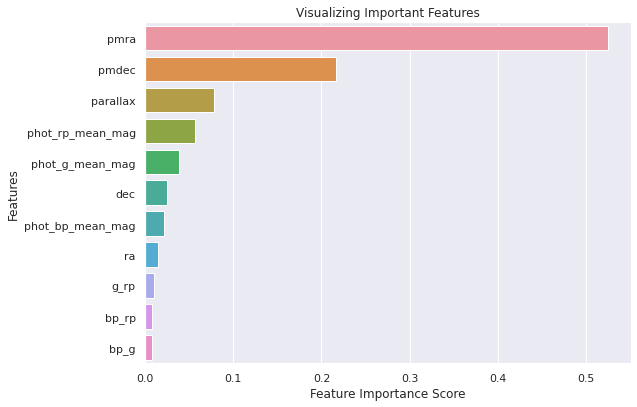

In [ ]:
# plotting as a barplot

# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to the graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

### Model Training and Prediction

In [ ]:
base_model = RandomForestClassifier(n_estimators = 7000, 
                                    max_features = 4,
                                    oob_score = True)
base_model.fit(features, targets)


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


RandomForestClassifier(max_features=4, n_estimators=7000, oob_score=True)

In [ ]:
base_model.oob_score_

0.9989930955120828

In [ ]:
## chosing only GAIA stars close to 2.5 degree radius of the center

coordinate = coord.SkyCoord.from_name('M67')
print(coordinate)
radius = u.Quantity(2.5, u.deg)
Gaia.ROW_LIMIT = -1
# table = "gaiaedr3.gaia_source"
table = "gaiadr2.gaia_source"
j = Gaia.cone_search_async(coordinate, radius)
r = j.get_results()
print(type(r))

<SkyCoord (ICRS): (ra, dec) in deg
    (132.846, 11.814)>
INFO: Query finished. [astroquery.utils.tap.core]
<class 'astropy.table.table.Table'>


In [ ]:
GAIA_target_stars = r.to_pandas()

GAIA_target_stars = GAIA_target_stars[GAIA_target_stars['parallax'] >= 0]

GAIA_target_stars = GAIA_target_stars[GAIA_target_stars.loc[:, 'bp_rp'].notnull()]

GAIA_target_stars = GAIA_target_stars[(abs(GAIA_target_stars['pmra']) < 20) & (abs(GAIA_target_stars['pmdec']) < 20)]

GAIA_target_stars.describe()

,solution_id,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,astrometric_matched_observations,visibility_periods_used,...,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,dist
count,7.098700e+04,7.098700e+04,7.098700e+04,70987.0,70987.000000,70987.000000,70987.000000,70987.000000,70987.000000,70987.000000,70987.000000,70987.000000,70987.000000,70987.000000,70987.000000,70987.000000,70987.000000,70987.000000,70987.000000,70987.000000,70987.000000,70987.000000,70987.000000,70987.000000,70987.000000,70987.000000,70987.000000,70987.000000,70987.000000,70987.000000,7.098700e+04,70987.000000,70987.000000,70987.0,70987.000000,70907.000000,70907.000000,70987.000000,70987.000000,70987.000000,...,70987.000000,70987.000000,70987.000000,7.098700e+04,70987.000000,70987.000000,70987.000000,70987.000000,70987.000000,70987.000000,70987.000000,70987.000000,1150.000000,1150.000000,70987.000000,1150.000000,1150.000000,1150.000000,70987.000000,70987.000000,70987.000000,70987.000000,19091.000000,19091.000000,19091.000000,19091.000000,14780.000000,14780.000000,14780.000000,14780.000000,14780.000000,14780.000000,14337.0,14337.000000,14337.000000,14337.000000,14337.000000,14337.000000,14337.000000,70987.000000
mean,1.635721e+18,6.031195e+17,8.493591e+08,2015.5,132.757990,0.356870,11.776840,0.238726,1.040891,0.442350,7.285448,-3.021211,0.733304,-3.653886,0.487744,-0.347930,-0.221725,-0.262136,0.171983,0.224113,0.273509,-0.671809,0.438712,-0.148860,-0.407236,303.598758,6.434756,301.622424,1.976334,1.918318,4.656566e+02,0.351893,4.604504,31.0,10.879716,1.467851,0.060933,0.025179,34.815530,11.966261,...,153.534576,18.793224,32.661558,2.382657e+04,46.985300,243.906891,17.290871,1.403405,0.016073,1.502459,0.641631,0.860833,22.691065,1.338720,0.202488,5393.217285,3.643478,-0.094565,215.685386,31.819903,131.902155,-5.657650,100021.712011,5347.558594,5160.619141,5624.434570,0.347589,0.201034,0.544336,0.172374,0.099434,0.269887,200111.0,1.530959,1.411662,1.629827,4.420034,3.915124,4.924970,1.628621
std,0.000000e+00,3.772720e+15,4.885702e+08,0.0,1.253718,0.372633,1.233941,0.254779,0.896286,0.458192,12.647858,5.810404,0.752267,5.417125,0.531030,0.153137,0.174651,0.174069,0.194524,0.203885,0.176033,0.116651,0.176366,0.215122,0.133001,64.310980,43.706676,63.912063,2.325105,8.808780,5.203416e+03,0.705065,106.483105,0.0,41.923058,0.143617,0.060253,0.048247,7.266984,1.258506,...,265.942200,2.213848,7.294334,9.805792e+05,2736.694237,367.252655,1.925121,0.229112,0.125759,0.585034,0.343229,0.295831,33.306722,1.703387,1.658830,646.623230,0.713741,0.332335,1.450804,1.228807,1.233214,1.234005,202.287314,669.781311,643.016357,745.895874,0.350614,0.275729,0.429756,0.174909,0.136835,0.215108,0.0,2.990820,2.782772,3.180019,32.316772,28.910522,35.820766,0.620369
min,1.635721e+18,5.972678e+17,2.351200e+04,2015.5,130.293414,0.016709,9.317264,0.010515,0.

In [ ]:
GAIA_target_stars = GAIA_target_stars.dropna(subset = feature_columns)
len(GAIA_target_stars)

70987

In [ ]:
# select the set of predictor variables from the new dataset
new_features = GAIA_target_stars.loc[:, feature_columns]
new_features = new_features.astype('float32')

In [ ]:
# train the model again using all the features and targets of the previous dataset
# rfc.fit(features, targets)

In [ ]:
# estimate the membership classification of the stars
GAIA_target_stars['member'] = base_model.predict(new_features)
GAIA_target_stars['member'].value_counts()

0    69390
1     1597
Name: member, dtype: int64

### Comparing with Gao Paper

#### Members

Number of members found by Gao with a RF model with n_estimators = 7000:
* n(PMemb >= 0.6) = 1502
* n(PMemb >= 0.8) = 1361

In [ ]:
# estimate the membership probability of the stars
# here we used n_estimators = 7000
GAIA_target_stars['PMemb'] = base_model.predict_proba(new_features)[:,1]
print('n(PMemb >= 0.6) =', sum(GAIA_target_stars['PMemb'] >= 0.6))
print('n(PMemb >= 0.8) =', sum(GAIA_target_stars['PMemb'] >= 0.8))

n(PMemb >= 0.6) = 1531
n(PMemb >= 0.8) = 1372


In [ ]:
potentialMember = GAIA_target_stars[GAIA_target_stars['PMemb'] >= 0.6]
len(potentialMember)

1531

In [ ]:
potentialMember.describe()

,solution_id,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,astrometric_matched_observations,visibility_periods_used,...,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,dist,member,PMemb
count,1.391000e+03,1.391000e+03,1.391000e+03,1391.0,1391.000000,1391.000000,1391.000000,1391.000000,1391.000000,1391.000000,1391.000000,1391.000000,1391.000000,1391.000000,1391.000000,1391.000000,1391.000000,1391.000000,1391.000000,1391.000000,1391.000000,1391.000000,1391.000000,1391.000000,1391.000000,1391.000000,1391.000000,1391.000000,1391.000000,1391.000000,1391.000000,1391.000000,1.391000e+03,1391.0,1391.000000,1391.000000,1391.000000,1391.000000,1391.000000,1391.000000,...,1391.000000,1.391000e+03,1391.000000,1391.000000,1391.000000,1391.000000,1391.000000,1391.000000,1391.000000,1391.000000,85.000000,85.000000,1391.000000,85.000000,85.000000,85.000000,1391.000000,1391.000000,1391.000000,1391.000000,990.000000,990.000000,990.000000,990.000000,774.000000,774.000000,774.000000,774.000000,774.000000,774.000000,981.0,981.000000,981.000000,981.000000,981.000000,981.000000,981.000000,1391.000000,1391.0,1391.000000
mean,1.635721e+18,6.041420e+17,8.307578e+08,2015.5,132.855294,0.086739,11.818985,0.057162,1.137790,0.109494,21.191467,-10.987865,0.182302,-2.941763,0.125205,-0.298222,-0.214112,-0.225791,0.113003,0.201602,0.255062,-0.650676,0.387175,-0.092765,-0.402880,319.040978,34.384615,316.907261,2.133717,0.557989,337.925079,0.073369,5.043769e-01,31.0,50.326130,1.507945,0.015714,0.038174,36.401869,12.363767,...,34.932423,6.813714e+04,66.695350,711.839966,14.890652,1.289462,0.084831,1.334557,0.606641,0.727916,34.477466,2.139421,0.685838,5317.646973,3.376471,-0.052941,215.689964,31.930235,131.983499,-5.594704,100005.159596,5360.099121,5172.709473,5607.887695,0.367461,0.206888,0.572196,0.181711,0.101510,0.282087,200111.0,1.543561,1.425412,1.655846,4.298684,4.036675,4.560691,0.418338,1.0,0.961693
std,0.000000e+00,2.341329e+15,4.795247e+08,0.0,0.416344,0.110384,0.438808,0.076321,0.097940,0.140030,12.989364,0.270669,0.234674,0.237535,0.166617,0.100269,0.126608,0.129211,0.134802,0.156957,0.115026,0.083326,0.154043,0.184835,0.095731,34.842221,96.567899,34.619421,2.405200,4.059390,179.102036,0.210517,2.814216e+00,0.0,80.220573,0.104144,0.020254,0.031778,3.874502,0.732559,...,4.441761,5.105544e+05,560.026757,551.852478,1.974885,0.107373,0.278730,0.536536,0.292964,0.248158,4.055501,2.884324,2.886300,702.237305,0.710909,0.264727,0.521283,0.403504,0.418695,0.430153,89.843076,673.400085,644.681458,740.562683,0.302923,0.240083,0.368717,0.150717,0.117348,0.183571,0.0,2.894890,2.719741,3.089322,27.722994,26.127573,29.319321,0.428506,0.0,0.073389
min,1.635721e+18,5.975889e+17,1.427216e+06,2015.5,130.457050,0.018080,9.424076,0.011963,0.832595,0.021383,0.570089,-11.768402,0.037657,-3.600932,0.025969,-0.795347,-0.810287,-0.644119,-0.448784,-0.455329,-0.340119,-0.907704,-0.264747,-0.5

In [ ]:
member.describe()

,solution_id,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,astrometric_matched_observations,visibility_periods_used,...,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,dist,distance_pc,PMemb,gmm_label
count,1.230000e+03,1.230000e+03,1.230000e+03,1230.0,1230.000000,1230.000000,1230.000000,1230.000000,1230.000000,1230.000000,1230.000000,1230.000000,1230.000000,1230.000000,1230.000000,1230.000000,1230.000000,1230.000000,1230.000000,1230.000000,1230.000000,1230.000000,1230.000000,1230.000000,1230.000000,1230.000000,1230.000000,1230.000000,1230.000000,1230.000000,1230.000000,1230.000000,1.230000e+03,1230.0,1230.000000,1230.000000,1230.000000,1230.000000,1230.000000,1230.000000,...,1.230000e+03,1230.000000,1230.000000,1230.000000,1230.000000,1230.000000,1230.000000,1230.000000,1230.000000,82.000000,82.000000,1230.000000,82.000000,82.000000,82.000000,1230.000000,1230.000000,1230.000000,1230.000000,910.000000,910.000000,910.000000,910.000000,711.000000,711.000000,711.000000,711.000000,711.000000,711.000000,901.0,901.000000,901.000000,901.000000,901.000000,901.000000,901.000000,1230.000000,1230.000000,1230.000000,1230.0
mean,1.635721e+18,6.042444e+17,8.398234e+08,2015.5,132.855318,0.075799,11.833071,0.049636,1.139779,0.095669,21.992762,-10.979209,0.159112,-2.944685,0.109123,-0.296728,-0.214408,-0.223014,0.110468,0.200915,0.254099,-0.649249,0.383910,-0.089676,-0.403609,319.482927,37.036585,317.309756,2.173171,0.558638,339.002777,0.061169,5.184304e-01,31.0,53.387398,1.514782,0.013711,0.038448,36.447154,12.391870,...,7.385543e+04,72.428166,741.023499,14.748794,1.281607,0.089431,1.302914,0.590077,0.712837,34.505410,2.155969,0.746341,5323.170898,3.335366,-0.054878,215.675153,31.936707,131.979682,-5.581396,100005.516484,5365.862793,5178.362305,5613.392090,0.373577,0.212038,0.580534,0.184908,0.103988,0.286258,200111.0,1.574975,1.454558,1.689878,4.496355,4.222878,4.769835,0.308903,883.777339,0.993530,0.0
std,0.000000e+00,2.095610e+15,4.808000e+08,0.0,0.275437,0.084111,0.270699,0.055544,0.096267,0.106374,12.777037,0.244219,0.175220,0.214482,0.121177,0.098260,0.123298,0.127582,0.133440,0.150142,0.112397,0.081782,0.151476,0.181754,0.094659,31.775570,99.511506,31.583217,2.473639,4.166442,181.801208,0.171621,2.886929e+00,0.0,82.212303,0.098738,0.015285,0.031192,3.501024,0.665993,...,5.408160e+05,594.837382,551.114136,1.923809,0.098138,0.285481,0.517956,0.283275,0.237993,4.115519,2.916873,2.984754,708.728333,0.689672,0.269386,0.327179,0.262389,0.275910,0.265589,93.704749,677.892761,651.828796,739.942932,0.308168,0.244864,0.375934,0.153314,0.119642,0.187139,0.0,2.993476,2.811510,3.195753,28.830927,27.171257,30.491552,0.225610,76.956210,0.008663,0.0
min,1.635721e+18,5.986167e+17,1.427216e+06,2015.5,131.915152,0.018080,10.889397,0.011963,0.805691,0.021383,1.531933,-11.743605,0.037657,-3.600932,0.025969,-0.795347,-0.810287,-0.644119,-0.448784,-0.293585,-0.340119,-0.907704,-0.127192,

#### Figure 4
PMemb from RF as a function of G band Magnitude and distance from cluster center.

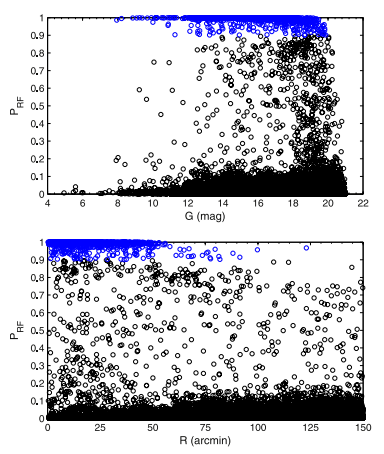

PMemb $\geq$ 0.9 are colored in blue.

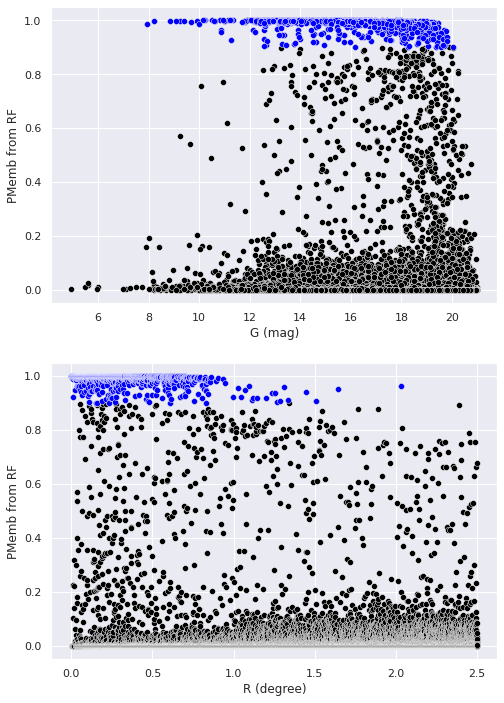

In [ ]:
plt.figure(figsize = (8, 12))

PMemb_mask = GAIA_target_stars.PMemb >= 0.9
plt.subplot(211)
sns.scatterplot(x='phot_g_mean_mag', y = 'PMemb', data = GAIA_target_stars, 
                color = 'black')
sns.scatterplot(x='phot_g_mean_mag', y = 'PMemb', 
                data = GAIA_target_stars[PMemb_mask], 
                color = 'blue')
plt.xlabel('G (mag)')
plt.ylabel('PMemb from RF')
#plt.title('Member')

plt.subplot(212)
sns.scatterplot(x='dist', y = 'PMemb', data = GAIA_target_stars, 
                color = 'black')
sns.scatterplot(x='dist', y = 'PMemb', 
                data = GAIA_target_stars[PMemb_mask], 
                color = 'blue')
plt.xlabel('R (degree)')
plt.ylabel('PMemb from RF')
#plt.title('Non Member')
plt.show()

#### Figure 7: CMD

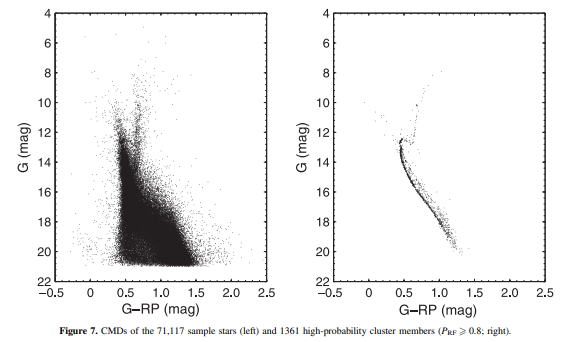

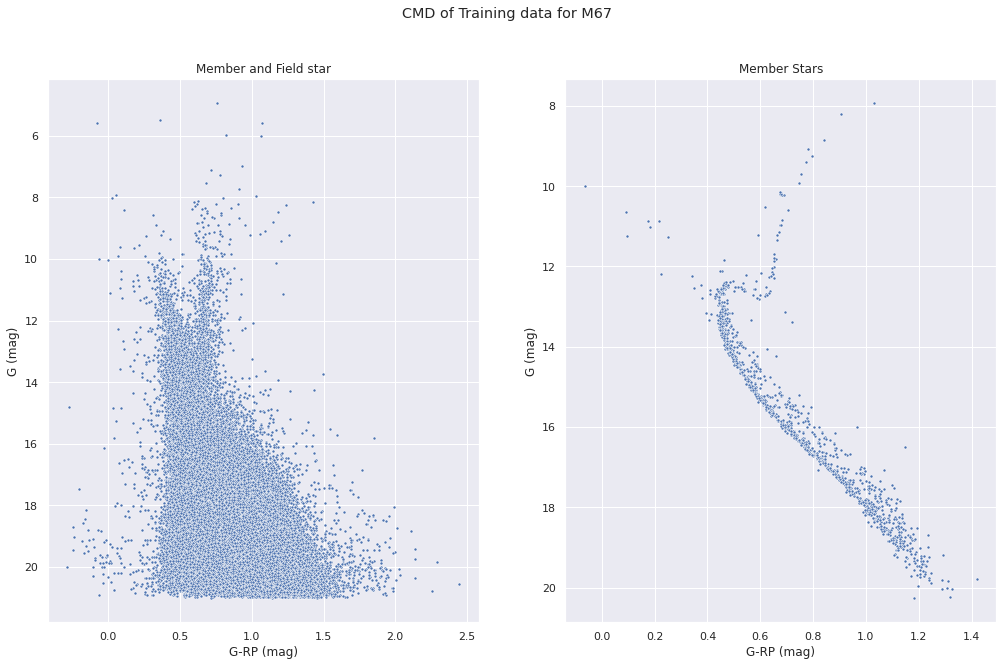

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(17,10))
fig.suptitle('CMD of Training data for M67')

sns.scatterplot(x = 'g_rp', y='phot_g_mean_mag',
                data = GAIA_target_stars, ax = axes[0], marker = '.')
axes[0].set_title('Member and Field star')
axes[0].set_xlabel('G-RP (mag)')
axes[0].set_ylabel('G (mag)')
axes[0].invert_yaxis()

PMemb_mask = GAIA_target_stars.PMemb >= 0.8

sns.scatterplot(x = 'g_rp', y='phot_g_mean_mag', marker = '.',
                data = GAIA_target_stars[PMemb_mask], ax = axes[1])
axes[1].set_title('Member Stars')
axes[1].set_xlabel('G-RP (mag)')
axes[1].set_ylabel('G (mag)')
axes[1].invert_yaxis()

plt.show()


#### Figure 8
Comparison between GMM and RF membership probabilities

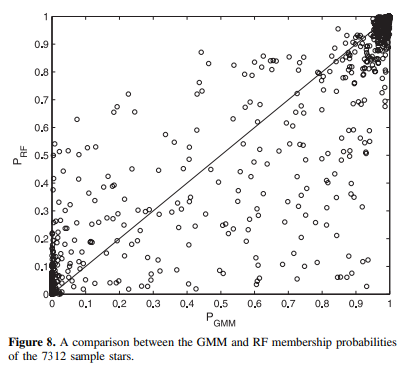

In [ ]:
all_stars_feature = all_stars.loc[:, feature_columns]
all_stars['PMemb_RF'] = base_model.predict_proba(all_stars_feature)[:,1]

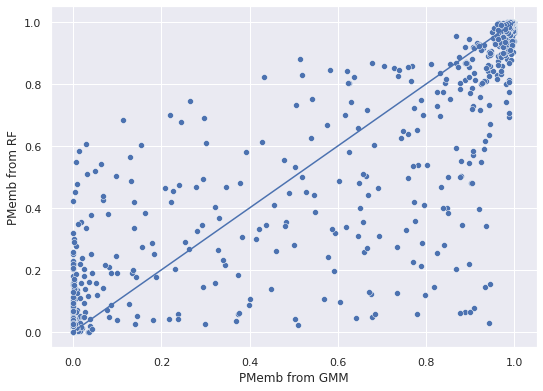

In [ ]:
sns.scatterplot(x = 'PMemb', y = 'PMemb_RF', data = all_stars)
plt.ylabel('PMemb from RF')
plt.xlabel('PMemb from GMM')
plt.plot([0,1],[0,1])
plt.show()

#### Other Visualization

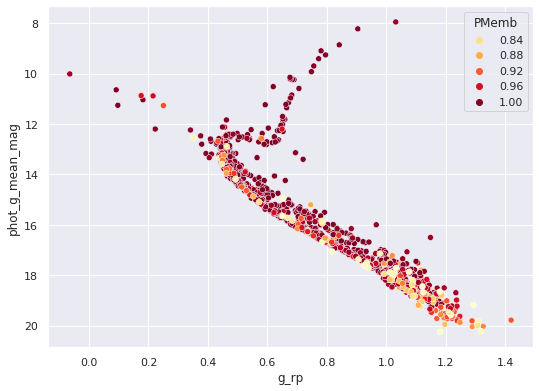

In [ ]:
# CMD of predicted members 

cmd = sns.scatterplot(x = 'g_rp', y = 'phot_g_mean_mag', hue= 'PMemb', 
                      palette='YlOrRd', data = GAIA_target_stars[GAIA_target_stars['PMemb'] >= 0.8] )
cmd.invert_yaxis()

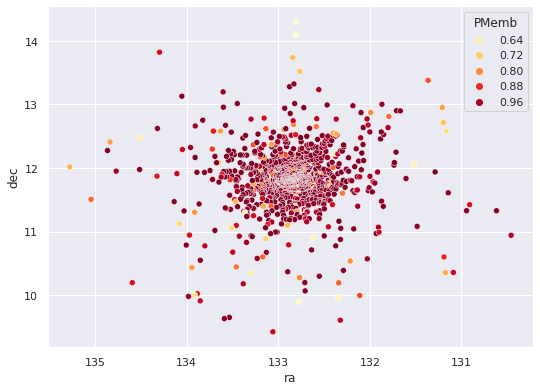

In [ ]:
skyplot = sns.scatterplot(x = 'ra', y = 'dec', hue= 'PMemb', 
                      palette='YlOrRd', data = GAIA_target_stars[GAIA_target_stars['PMemb'] >= 0.6] )
skyplot.invert_xaxis()
plt.show()


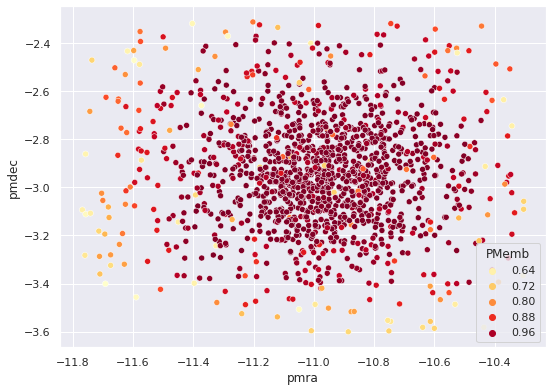

In [ ]:
# pm plot
sns.scatterplot(x = 'pmra', y = 'pmdec', hue= 'PMemb', 
                      palette='YlOrRd', data = GAIA_target_stars[GAIA_target_stars['PMemb'] >= 0.6] )
plt.show()


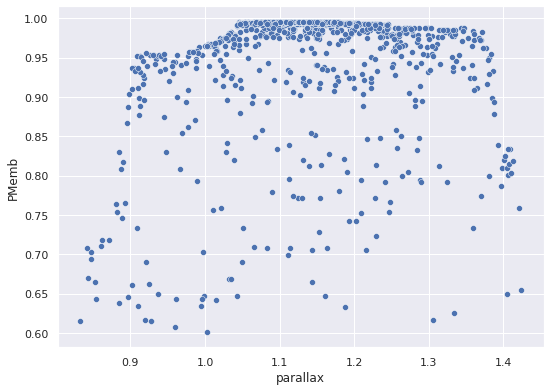

In [ ]:
# parallax plot
sns.scatterplot(x = 'parallax', y = 'PMemb',  
                      palette='YlOrRd', data = GAIA_target_stars[GAIA_target_stars['PMemb'] >= 0.6] )

In [ ]:
# saving the files as csv
# all_stars.to_csv('gaia_6405_membership_prob.csv')

potentialMember.to_csv('M_67_membership_prob.csv')


### Comparing the old and new predicted members

In [ ]:
# creating subset for the potential member in previous dataset

concatenated = pd.concat([potentialMember.assign(dataset='New_member'), member.assign(dataset='Old_member')])
concatenated.head()

,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,...,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,phot_variable_flag,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,datalink_url,dist,member,PMemb,dataset,distance_pc,gmm_label
0,1635721458409799680,Gaia DR2 604917629355038848,604917629355038848,309606362,2015.5,132.845427,0.033842,11.813721,0.022365,1.129222,0.042616,26.497473,-10.956961,0.071723,-3.093306,0.051006,-0.195550,-0.170198,-0.157318,-0.074163,0.217768,0.129410,-0.505363,0.261068,0.050572,-0.386716,270,270,268,2,6.030247,426.040680,0.000000,0.000000,31,True,245.371384,1.627914,0.006196,0.055473,...,1.204024,1,0.741670,0.292775,0.448895,NaN,NaN,0,NaN,NaN,NaN,NOT_AVAILABLE,215.691180,31.920163,131.975615,-5.602846,100002,6320.979980,6052.333496,6652.666504,NaN,NaN,NaN,NaN,NaN,NaN,200111,1.939404,1.750837,2.115395,5.409647,5.116649,5.702646,https://gea.esac.esa.int/data-server/datalink/...,0.000629,1.0,0.995105,New_member,NaN,NaN
2,1635721458409799680,Gaia DR2 604917732434252032,604917732434252032,1037136882,2015.5,132.847883,0.047155,11.818284,0.028357,1.113444,0.059270,18.785810,-11.261058,0.099747,-3.060736,0.069823,-0.203317,-0.193954,-0.088213,-0.091070,0.198510,0.143394,-0.505099,0.266576,0.071134,-0.393377,305,0,304,1,-0.531459,285.544067,0.000000,0.000000,31,False,9.124626,1.523387,0.008625,0.048264,...,1.261143,0,1.213900,0.520187,0.693712,NaN,NaN,0,NaN,NaN,NaN,NOT_AVAILABLE,215.687482,31.924256,131.976693,-5.597801,100001,4880.000000,4811.924805,5016.500000,NaN,NaN,NaN,NaN,NaN,NaN,200111,0.748697,0.708507,0.770030,0.286409,0.253650,0.319167,https://gea.esac.esa.int/data-server/datalink/...,0.004667,1.0,0.994895,New_member,NaN,NaN
3,1635721458409799680,Gaia DR2 604917732434325248,604917732434325248,1685360922,2015.5,132.845628,0.023422,11.820310,0.014362,1.125087,0.028212,39.879951,-10.902709,0.049980,-3.153121,0.033065,-0.114846,-0.047632,-0.194107,-0.122447,0.224214,0.041213,-0.483801,0.205225,0.025290,-0.329040,263,0,258,5,1.481120,287.074982,0.062990,1.277349,31,False,83.750946,1.654632,0.003962,0.068040,...,1.201937,0,0.629848,0.236272,0.393577,NaN,NaN,0,NaN,NaN,NaN,NOT_AVAILABLE,215.684227,31.923100,131.974006,-5.596452,100001,6845.333496,6356.000000,6994.666504,0.2835,0.1735,0.5501,0.1392,0.0740,0.2746,200111,1.255830,1.202780,1.456640,3.119858,2.927116,3.312600,https://gea.esac.esa.int/data-server/datalink/...,0.006326,1.0,0.995241,New_member,NaN,NaN
4,1635721458409799680,Gaia DR2 604917629355039360,604917629355039360,340729517,2015.5,132.846939,0.039546,11.807362,0.023041,1.111626,0.047573,23.366507,-10.978362,0.085649,-3.395680,0.056500,-0.188175,-0.164693,0.031988,-0.101328,0.184592,0.083166,-0.472924,0.213145,0.061962,-0.342663,288,0,288,0,12.284073,686.185303,0.226969,13.566716,31,False,14.085754,1.546124,0.006565,0.058586,...,1.238919,0,1.079499,0.455420,0.624079,NaN,NaN,0,NaN,NaN,NaN,NOT_AVAILABLE,215.698714,31.918846,131.978783,-5.608563,100001,4932.049805,4844.333496,5044.100098,1.0960,0.7820,1.3225,0.5375,0

In [ ]:
concatenated.reset_index(drop=True)

,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,...,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,phot_variable_flag,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,datalink_url,dist,member,PMemb,dataset,distance_pc,gmm_label
0,1635721458409799680,Gaia DR2 604917629355038848,604917629355038848,309606362,2015.5,132.845427,0.033842,11.813721,0.022365,1.129222,0.042616,26.497473,-10.956961,0.071723,-3.093306,0.051006,-0.195550,-0.170198,-0.157318,-0.074163,0.217768,0.129410,-0.505363,0.261068,0.050572,-0.386716,270,270,268,2,6.030247,426.040680,0.000000,0.000000,31,True,245.371384,1.627914,0.006196,0.055473,...,1.204024,1,0.741670,0.292775,0.448895,NaN,NaN,0,NaN,NaN,NaN,NOT_AVAILABLE,215.691180,31.920163,131.975615,-5.602846,100002,6320.979980,6052.333496,6652.666504,NaN,NaN,NaN,NaN,NaN,NaN,200111,1.939404,1.750837,2.115395,5.409647,5.116649,5.702646,https://gea.esac.esa.int/data-server/datalink/...,0.000629,1.0,0.995105,New_member,NaN,NaN
1,1635721458409799680,Gaia DR2 604917732434252032,604917732434252032,1037136882,2015.5,132.847883,0.047155,11.818284,0.028357,1.113444,0.059270,18.785810,-11.261058,0.099747,-3.060736,0.069823,-0.203317,-0.193954,-0.088213,-0.091070,0.198510,0.143394,-0.505099,0.266576,0.071134,-0.393377,305,0,304,1,-0.531459,285.544067,0.000000,0.000000,31,False,9.124626,1.523387,0.008625,0.048264,...,1.261143,0,1.213900,0.520187,0.693712,NaN,NaN,0,NaN,NaN,NaN,NOT_AVAILABLE,215.687482,31.924256,131.976693,-5.597801,100001,4880.000000,4811.924805,5016.500000,NaN,NaN,NaN,NaN,NaN,NaN,200111,0.748697,0.708507,0.770030,0.286409,0.253650,0.319167,https://gea.esac.esa.int/data-server/datalink/...,0.004667,1.0,0.994895,New_member,NaN,NaN
2,1635721458409799680,Gaia DR2 604917732434325248,604917732434325248,1685360922,2015.5,132.845628,0.023422,11.820310,0.014362,1.125087,0.028212,39.879951,-10.902709,0.049980,-3.153121,0.033065,-0.114846,-0.047632,-0.194107,-0.122447,0.224214,0.041213,-0.483801,0.205225,0.025290,-0.329040,263,0,258,5,1.481120,287.074982,0.062990,1.277349,31,False,83.750946,1.654632,0.003962,0.068040,...,1.201937,0,0.629848,0.236272,0.393577,NaN,NaN,0,NaN,NaN,NaN,NOT_AVAILABLE,215.684227,31.923100,131.974006,-5.596452,100001,6845.333496,6356.000000,6994.666504,0.2835,0.1735,0.5501,0.1392,0.0740,0.2746,200111,1.255830,1.202780,1.456640,3.119858,2.927116,3.312600,https://gea.esac.esa.int/data-server/datalink/...,0.006326,1.0,0.995241,New_member,NaN,NaN
3,1635721458409799680,Gaia DR2 604917629355039360,604917629355039360,340729517,2015.5,132.846939,0.039546,11.807362,0.023041,1.111626,0.047573,23.366507,-10.978362,0.085649,-3.395680,0.056500,-0.188175,-0.164693,0.031988,-0.101328,0.184592,0.083166,-0.472924,0.213145,0.061962,-0.342663,288,0,288,0,12.284073,686.185303,0.226969,13.566716,31,False,14.085754,1.546124,0.006565,0.058586,...,1.238919,0,1.079499,0.455420,0.624079,NaN,NaN,0,NaN,NaN,NaN,NOT_AVAILABLE,215.698714,31.918846,131.978783,-5.608563,100001,4932.049805,4844.333496,5044.100098,1.0960,0.7820,1.3225,0.5375,0

In [ ]:
concatenated.describe()

,solution_id,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,astrometric_matched_observations,visibility_periods_used,...,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,dist,member,PMemb,distance_pc,gmm_label
count,2.621000e+03,2.621000e+03,2.621000e+03,2621.0,2621.000000,2621.000000,2621.000000,2621.000000,2621.000000,2621.000000,2621.000000,2621.000000,2621.000000,2621.000000,2621.000000,2621.000000,2621.000000,2621.000000,2621.000000,2621.000000,2621.000000,2621.000000,2621.000000,2621.000000,2621.000000,2621.000000,2621.000000,2621.000000,2621.000000,2621.000000,2621.000000,2621.000000,2.621000e+03,2621.0,2621.000000,2621.000000,2621.000000,2621.000000,2621.000000,2621.000000,...,2621.000000,2621.000000,2621.000000,2621.000000,2621.000000,2621.000000,2621.000000,2621.000000,167.000000,167.000000,2621.000000,167.000000,167.000000,167.000000,2621.000000,2621.000000,2621.000000,2621.000000,1900.000000,1900.000000,1900.000000,1900.000000,1485.000000,1485.000000,1485.000000,1485.000000,1485.000000,1485.000000,1882.0,1882.000000,1882.000000,1882.000000,1882.000000,1882.000000,1882.000000,2621.000000,1391.0,2621.000000,1230.000000,1230.0
mean,1.635721e+18,6.041900e+17,8.350122e+08,2015.5,132.855305,0.081605,11.825595,0.053630,1.138724,0.103006,21.567484,-10.983803,0.171419,-2.943135,0.117658,-0.297521,-0.214250,-0.224488,0.111813,0.201279,0.254610,-0.650006,0.385643,-0.091315,-0.403222,319.248378,35.629149,317.096147,2.152232,0.558294,338.430359,0.067644,5.109720e-01,31.0,51.762711,1.511154,0.014774,0.038303,36.423121,12.376955,...,69.385683,725.535889,14.824068,1.285775,0.086990,1.319708,0.598868,0.720840,34.491187,2.147546,0.714231,5320.359375,3.356287,-0.053892,215.683013,31.933272,131.981707,-5.588459,100005.330526,5362.865234,5175.417969,5610.524414,0.370389,0.209354,0.576188,0.183241,0.102697,0.284084,200111.0,1.558599,1.439366,1.672140,4.393323,4.125822,4.660820,0.366982,1.0,0.976633,883.777339,0.0
std,0.000000e+00,2.229557e+15,4.800533e+08,0.0,0.357143,0.099059,0.369566,0.067465,0.097145,0.125532,12.893899,0.258581,0.209173,0.226970,0.147243,0.099315,0.125042,0.128432,0.134145,0.153768,0.113779,0.082592,0.152823,0.183367,0.095212,33.432542,97.950489,33.223473,2.437169,4.109188,180.340073,0.193301,2.848033e+00,0.0,81.160172,0.101681,0.018117,0.031499,3.703297,0.702115,...,576.520901,551.593506,1.951997,0.103198,0.281874,0.528034,0.288522,0.243511,4.072775,2.891611,2.932508,703.309082,0.698755,0.266220,0.440946,0.344507,0.358774,0.362350,91.688842,675.383301,647.949768,740.076111,0.305358,0.242316,0.372087,0.151923,0.118418,0.185237,0.0,2.941756,2.763356,3.139935,28.251463,26.625395,29.878468,0.352527,0.0,0.056082,76.956210,0.0
min,1.635721e+18,5.975889e+17,1.427216e+06,2015.5,130.457050,0.018080,9.424076,0.011963,0.805691,0.021383,0.570089,-11.768402,0.037657,-3.600932,0.025969,-0.795347,-0.810287,-0.644119,-0.448784,-0.455329,-0.340119,-0.907704,-0.264747,-0.569143,-0.7

In [ ]:
member.describe()

,solution_id,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,astrometric_matched_observations,visibility_periods_used,...,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,dist,distance_pc,PMemb,gmm_label
count,1.230000e+03,1.230000e+03,1.230000e+03,1230.0,1230.000000,1230.000000,1230.000000,1230.000000,1230.000000,1230.000000,1230.000000,1230.000000,1230.000000,1230.000000,1230.000000,1230.000000,1230.000000,1230.000000,1230.000000,1230.000000,1230.000000,1230.000000,1230.000000,1230.000000,1230.000000,1230.000000,1230.000000,1230.000000,1230.000000,1230.000000,1230.000000,1230.000000,1.230000e+03,1230.0,1230.000000,1230.000000,1230.000000,1230.000000,1230.000000,1230.000000,...,1.230000e+03,1230.000000,1230.000000,1230.000000,1230.000000,1230.000000,1230.000000,1230.000000,1230.000000,82.000000,82.000000,1230.000000,82.000000,82.000000,82.000000,1230.000000,1230.000000,1230.000000,1230.000000,910.000000,910.000000,910.000000,910.000000,711.000000,711.000000,711.000000,711.000000,711.000000,711.000000,901.0,901.000000,901.000000,901.000000,901.000000,901.000000,901.000000,1230.000000,1230.000000,1230.000000,1230.0
mean,1.635721e+18,6.042444e+17,8.398234e+08,2015.5,132.855318,0.075799,11.833071,0.049636,1.139779,0.095669,21.992762,-10.979209,0.159112,-2.944685,0.109123,-0.296728,-0.214408,-0.223014,0.110468,0.200915,0.254099,-0.649249,0.383910,-0.089676,-0.403609,319.482927,37.036585,317.309756,2.173171,0.558638,339.002777,0.061169,5.184304e-01,31.0,53.387398,1.514782,0.013711,0.038448,36.447154,12.391870,...,7.385543e+04,72.428166,741.023499,14.748794,1.281607,0.089431,1.302914,0.590077,0.712837,34.505410,2.155969,0.746341,5323.170898,3.335366,-0.054878,215.675153,31.936707,131.979682,-5.581396,100005.516484,5365.862793,5178.362305,5613.392090,0.373577,0.212038,0.580534,0.184908,0.103988,0.286258,200111.0,1.574975,1.454558,1.689878,4.496355,4.222878,4.769835,0.308903,883.777339,0.993530,0.0
std,0.000000e+00,2.095610e+15,4.808000e+08,0.0,0.275437,0.084111,0.270699,0.055544,0.096267,0.106374,12.777037,0.244219,0.175220,0.214482,0.121177,0.098260,0.123298,0.127582,0.133440,0.150142,0.112397,0.081782,0.151476,0.181754,0.094659,31.775570,99.511506,31.583217,2.473639,4.166442,181.801208,0.171621,2.886929e+00,0.0,82.212303,0.098738,0.015285,0.031192,3.501024,0.665993,...,5.408160e+05,594.837382,551.114136,1.923809,0.098138,0.285481,0.517956,0.283275,0.237993,4.115519,2.916873,2.984754,708.728333,0.689672,0.269386,0.327179,0.262389,0.275910,0.265589,93.704749,677.892761,651.828796,739.942932,0.308168,0.244864,0.375934,0.153314,0.119642,0.187139,0.0,2.993476,2.811510,3.195753,28.830927,27.171257,30.491552,0.225610,76.956210,0.008663,0.0
min,1.635721e+18,5.986167e+17,1.427216e+06,2015.5,131.915152,0.018080,10.889397,0.011963,0.805691,0.021383,1.531933,-11.743605,0.037657,-3.600932,0.025969,-0.795347,-0.810287,-0.644119,-0.448784,-0.293585,-0.340119,-0.907704,-0.127192,

In [ ]:
concatenated.dataset.value_counts()

New_member    1391
Old_member    1230
Name: dataset, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

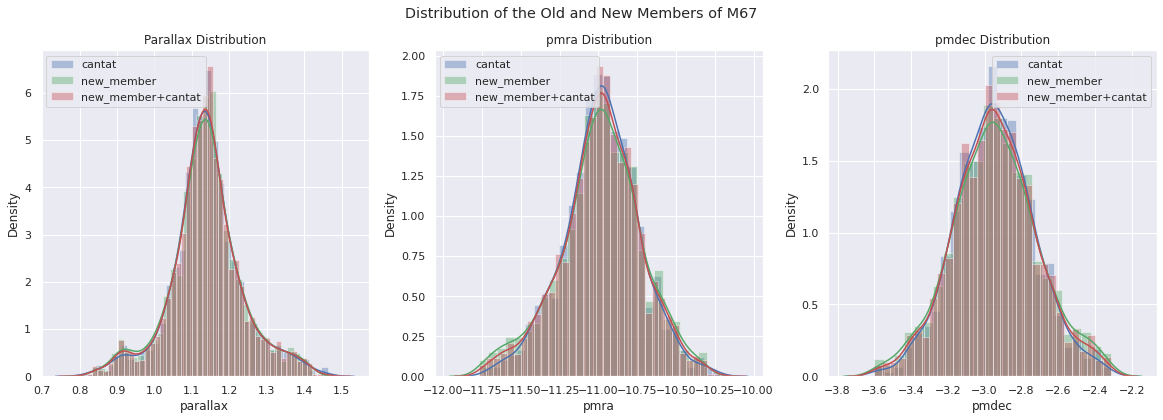

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20,6))
fig.suptitle('Distribution of the Old and New Members of M67')


sns.distplot(member['parallax'], color = 'b', label = 'cantat', 
             kde=True, ax=axes[0])
sns.distplot(potentialMember['parallax'], color = 'g', label = 'new_member', 
             kde=True, ax=axes[0])
sns.distplot(concatenated['parallax'], color = 'r', ax=axes[0], kde=True,
             label = 'new_member+cantat')
axes[0].set_title('Parallax Distribution')
axes[0].legend()

sns.distplot(member['pmra'], color = 'b', label = 'cantat', 
             kde=True, ax=axes[1])
sns.distplot(potentialMember['pmra'], color = 'g', label = 'new_member', 
             kde=True, ax=axes[1])
sns.distplot(concatenated['pmra'], color = 'r', ax=axes[1], kde=True,
             label = 'new_member+cantat')
axes[1].set_title('pmra Distribution')
axes[1].legend()

sns.distplot(member['pmdec'], color = 'b', label = 'cantat', 
             kde=True, ax=axes[2])
sns.distplot(potentialMember['pmdec'], color = 'g', label = 'new_member', 
             kde=True, ax=axes[2])
sns.distplot(concatenated['pmdec'], color = 'r', ax=axes[2], kde=True,
             label = 'new_member+cantat')
axes[2].set_title('pmdec Distribution')
axes[2].legend()

plt.show()


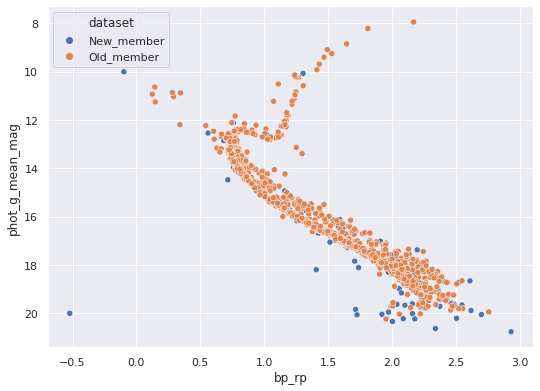

In [ ]:
cmd = sns.scatterplot(x='bp_rp', y='phot_g_mean_mag', data=concatenated,
                hue='dataset')
cmd.invert_yaxis()

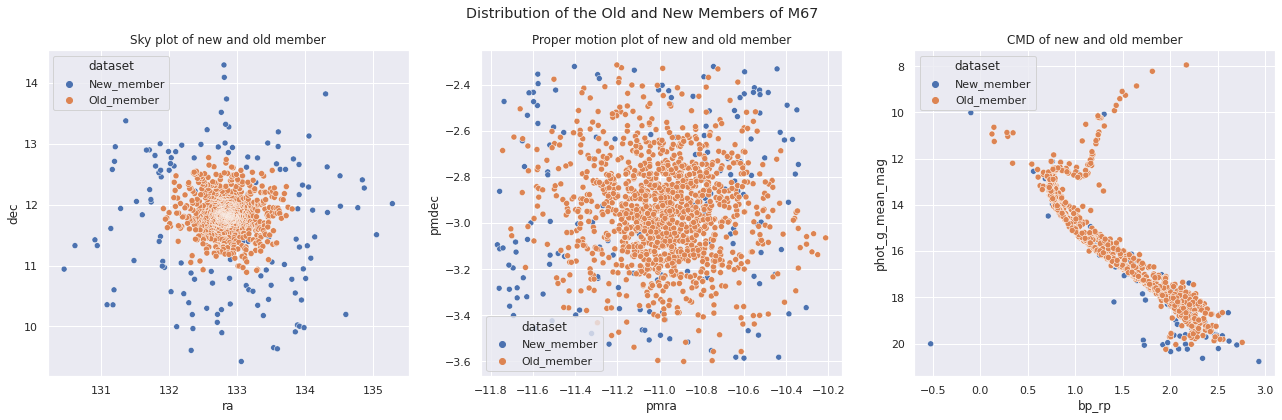

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(22,6))
fig.suptitle('Distribution of the Old and New Members of M67')

skyplot = sns.scatterplot(x='ra', y='dec', data=concatenated,
                hue='dataset', ax=axes[0])
axes[0].set_title('Sky plot of new and old member')

# proper motion plot
sns.scatterplot(x='pmra', y='pmdec', data=concatenated,
                hue='dataset', ax=axes[1])
axes[1].set_title('Proper motion plot of new and old member')

cmd = sns.scatterplot(x='bp_rp', y='phot_g_mean_mag', data=concatenated,
                hue='dataset', ax=axes[2])
cmd.invert_yaxis()
axes[2].set_title('CMD of new and old member')

plt.show()

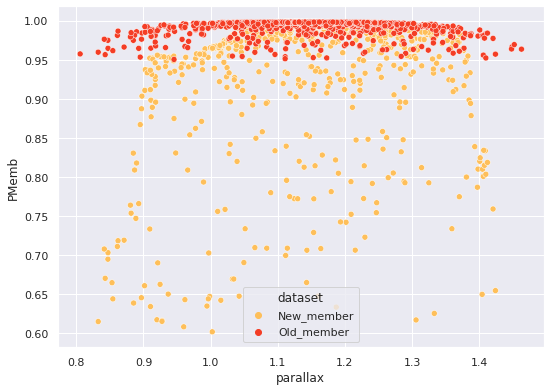

In [ ]:
# parallax vs PMemb plot
sns.scatterplot(x = 'parallax', y = 'PMemb',  hue = 'dataset',
                      palette='YlOrRd', data = concatenated )

In [ ]:
# pd_prof.ProfileReport(potentialMember)

In [ ]:
#files.download('M_67_cantat.csv')

#files.download('M_67_membership_prob.csv')

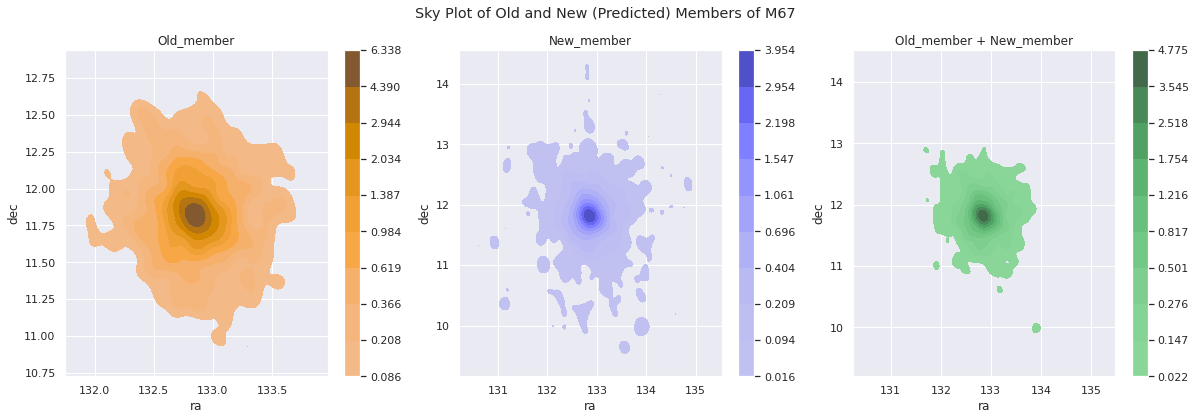

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20,6))
fig.suptitle('Sky Plot of Old and New (Predicted) Members of M67')

sns.kdeplot(x='ra', y='dec', data = member, shade=True, color = 'orange', 
            bw_method = 0.20, cbar=True, ax=axes[0])
axes[0].set_title('Old_member')

sns.kdeplot(x='ra', y='dec', data = potentialMember, shade=True, color = 'blue', 
            bw_method = 0.20, cbar=True, ax=axes[1])
axes[1].set_title('New_member')

sns.kdeplot(x='ra', y='dec', data = concatenated.reset_index(drop=True), shade=True, color = 'g', 
            bw_method = 0.20, cbar=True, ax=axes[2])
axes[2].set_title('Old_member + New_member')

plt.show()

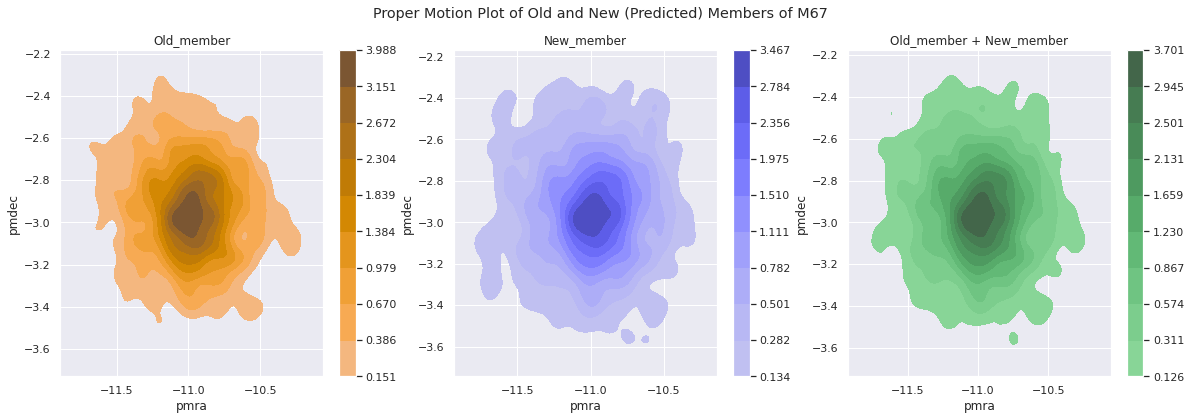

In [ ]:

fig, axes = plt.subplots(1, 3, figsize=(20,6))
fig.suptitle('Proper Motion Plot of Old and New (Predicted) Members of M67')

sns.kdeplot(x='pmra', y='pmdec', data = member, shade=True, color = 'orange', 
            bw_method = 0.20, cbar=True, ax=axes[0])
axes[0].set_title('Old_member')

sns.kdeplot(x='pmra', y='pmdec', data = potentialMember, shade=True, color = 'blue', 
            bw_method = 0.20, cbar=True, ax=axes[1])
axes[1].set_title('New_member')

sns.kdeplot(x='pmra', y='pmdec', data = concatenated.reset_index(drop=True), shade=True, color = 'g', 
            bw_method = 0.20, cbar=True, ax=axes[2])
axes[2].set_title('Old_member + New_member')

plt.show()

In [ ]:
from google.colab import files

In [ ]:

potentialMember.to_csv('M_67_additional_member_prob.csv')
concatenated.to_csv('M_67_all_member_prob.csv')

#files.download('M_67_all_member_prob.csv')
# column 'dataset': Old_member, New_member
# column 'member': 0 and 1
# column 'PMemb': decimal values between 0 to 1

#files.download('M_67_additional_member_prob.csv')
